In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES']=''

os.chdir('/home/kuratov/t5-experiments')
print(os.getcwd())

/cephfs/home/kuratov/t5-experiments


In [2]:
import json

import torch
from pathlib import Path

from deeppavlov import build_model
from deeppavlov.core.common.params import from_params
from deeppavlov.core.commands.train import read_data_by_config, get_iterator_from_config
from deeppavlov.core.commands.utils import parse_config

from dp import T5Text2TextModel, T5DatasetReader, T5TFDatasetIterator, TorchTransformersPreprocessor

In [ ]:
# config_path - path to the DP config for finetuned model

In [3]:
config_path = './runs/small_wiki_bs_128_enc_mem_20/glue/mixture/bs_128/config.json'

task = 'glue/qqp'

checkpoint = None
mixture = False
if 'mixture' in config_path:
    mixture = True
    checkpoint = 'model_200000'

config = json.load(open(config_path))
config = parse_config(config)
if checkpoint:
    for component in config['chainer']['pipe']:
        if component.get('class_name', '') == 'dp:T5Text2TextModel':
            component['save_path'] = str(Path(component['save_path']).parent / checkpoint)
            component['load_path'] = str(Path(component['load_path']).parent / checkpoint)
model = build_model(config)

2021-04-23 19:06:49,946 - dp - INFO - Using optimizer <class 'torch.optim.adamw.AdamW'>
2021-04-23 19:06:49,948 - dp - INFO - Load path /cephfs/home/kuratov/t5-experiments/runs/small_wiki_bs_128_enc_mem_20/glue/mixture/bs_128/model_200000 is given.
2021-04-23 19:06:49,950 - dp - INFO - Load path /cephfs/home/kuratov/t5-experiments/runs/small_wiki_bs_128_enc_mem_20/glue/mixture/bs_128/model_200000.pth.tar exists.
2021-04-23 19:06:49,950 - dp - INFO - Initializing `T5Text2TextModel` from saved.
2021-04-23 19:06:49,951 - dp - INFO - Loading weights from /cephfs/home/kuratov/t5-experiments/runs/small_wiki_bs_128_enc_mem_20/glue/mixture/bs_128/model_200000.pth.tar.


Model was loaded from: runs/small_wiki_bs_128_enc_mem_20/model_1100000.pth


2021-04-23 19:06:50.688 INFO in 'deeppavlov.core.models.torch_model'['torch_model'] at line 98: Model was successfully initialized! Model summary:
 T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_

In [4]:
t5model = None
for _, _, component in model.pipe:
    if isinstance(component, T5Text2TextModel):
        t5model = component.model
        
preprocessor = None
for _, _, component in model.pipe:
    if isinstance(component, TorchTransformersPreprocessor):
        preprocessor = component

In [5]:
num_memory_tokens = 0
if hasattr(t5model.encoder, 'memory_tokens'):
    num_memory_tokens = t5model.encoder.memory_tokens.shape[0]
num_memory_tokens

20

In [6]:
if not mixture:
    dr = read_data_by_config(config)
    di = get_iterator_from_config(config, dr)
    p = preprocessor
else:
    task_config = json.load(open(f'./dp_configs/{task}.json'))
    task_config = parse_config(task_config)
    dr = read_data_by_config(task_config)
    di = get_iterator_from_config(task_config, dr)
    p = from_params(task_config['chainer']['pipe'][0])

2021-04-23 19:06:51,270 - absl - INFO - Load dataset info from /home/kuratov/tensorflow_datasets/glue/qqp/1.0.0
2021-04-23 19:06:51,274 - absl - INFO - Reusing dataset glue (/home/kuratov/tensorflow_datasets/glue/qqp/1.0.0)
2021-04-23 19:06:51,274 - absl - INFO - Constructing tf.data.Dataset for split train, from /home/kuratov/tensorflow_datasets/glue/qqp/1.0.0
/cephfs/home/kuratov/text-to-text-transfer-transformer/t5/seqio/preprocessors.py:64: UserWarning: Creating resources inside a function passed to Dataset.map() is not supported. Create each resource outside the function, and capture it inside the function to use it.
  return dataset.map(
2021-04-23 19:06:52,986 - absl - INFO - Load dataset info from /home/kuratov/tensorflow_datasets/glue/qqp/1.0.0
2021-04-23 19:06:53,586 - absl - INFO - Load dataset info from /home/kuratov/tensorflow_datasets/glue/qqp/1.0.0
2021-04-23 19:06:53,590 - absl - INFO - Reusing dataset glue (/home/kuratov/tensorflow_datasets/glue/qqp/1.0.0)
2021-04-23 1

In [7]:
from transformers import T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-base')

In [8]:
type(t5model)

modeling_t5.T5ForConditionalGeneration

In [9]:
x, y = None, None
for batch in di.gen_batches(batch_size=1, data_type='valid'):
    x, y = batch
    print('x:', x)
    print('y:', y)
    break
    
x_p = preprocessor(x)
y_p = preprocessor(y)
x, y = {}, {}
for inp, features in zip([x, y], [x_p, y_p]):
    for elem in ['input_ids', 'attention_mask']:
        inp[elem] = [getattr(f, elem) for f in features]
        inp[elem] = torch.stack(inp[elem], dim=0)

x: ('qqp question1: Who is going to be a better president - Hillary Clinton or Donald Trump? question2: In what aspects is Hillary Clinton better than Trump?',)
y: ('duplicate',)


In [33]:
outputs = t5model(input_ids=x['input_ids'], attention_mask=x['attention_mask'],
                  decoder_input_ids=y['input_ids'], decoder_attention_mask=y['attention_mask'],
                  return_dict=True, output_attentions=True, output_normalized_attentions=True)

In [34]:
outputs.keys()

odict_keys(['logits', 'past_key_values', 'decoder_attentions', 'cross_attentions', 'encoder_last_hidden_state', 'encoder_attentions'])

In [35]:
# 12
outputs['encoder_attentions'][0].shape

torch.Size([1, 8, 58, 58])

In [36]:
# 12
outputs['decoder_attentions'][0].shape

torch.Size([1, 8, 2, 2])

In [37]:
# 12
outputs['cross_attentions'][0].shape

torch.Size([1, 8, 2, 58])

In [30]:
# output_normalized_attentions=False
# outputs['cross_attentions'][0][0][0][0][:5]
# > tensor([0.0124, 0.0207, 0.0204, 0.0206, 0.0202], grad_fn=<SliceBackward>)

# output_normalized_attentions=True
# outputs['cross_attentions'][0][0][0][0][:5]
# > tensor([0.0754, 0.0459, 0.0461, 0.0456, 0.0447], grad_fn=<SliceBackward>)

tensor([0.0754, 0.0459, 0.0461, 0.0456, 0.0447], grad_fn=<SliceBackward>)

In [38]:
# 12
# cdQ_attention
if isinstance(outputs['encoder_attentions'][0], tuple):
    if outputs['encoder_attentions'][0][0] is not None:
        # model has cdq and regular attention heads
        print('attentions:', outputs['encoder_attentions'][0][0].shape)
    print('cdQ attentions:', outputs['encoder_attentions'][0][1].shape)
    print('P_attentions:', outputs['encoder_attentions'][0][2].shape)

In [39]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

def plot_attention_weights(attentions, tokens, layer, y_tokens=None, p_attentions=None, filename='att.png', save=False, figsize=(30, 90)):
    # attentions n_layers x n_heads x len x len
    fig = plt.figure(figsize=figsize)
    if y_tokens is None: 
        y_tokens = tokens

    attention = attentions[layer]
    if p_attentions:
        p_attention = p_attentions[layer]

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(6, 2, head+1)

        # plot the attention weights
        if p_attentions:
            att = np.concatenate([np.expand_dims(p_attention[head], axis=0), attention[head]], axis=0)
            ax.matshow(att[:len(y_tokens)+1,:len(tokens)], cmap='Reds')
        else:
            ax.matshow(attention[head][:len(y_tokens),:len(tokens)], cmap='Reds')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(tokens)))
        if p_attentions:
            ax.set_yticks(range(len(y_tokens) + 1))
            ax.set_yticklabels(['[P]'] + y_tokens, fontdict)
        else:
            ax.set_yticks(range(len(y_tokens)))
            ax.set_yticklabels(y_tokens, fontdict)

        ax.set_xticklabels(tokens,fontdict=fontdict, rotation=90)

        ax.set_xlabel('Head {}'.format(head+1), fontdict)

    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show()

In [40]:
def get_actual_seq_len(tokens):
    if '<pad>' in tokens:
        return tokens.index('<pad>')
    return len(tokens)

tokens = [tokenizer.convert_ids_to_tokens(t_id).replace('▁', '') for t_id in x['input_ids'][0].tolist()]
y_tokens = [tokenizer.convert_ids_to_tokens(t_id).replace('▁', '') for t_id in y['input_ids'][0].tolist()]

tokens = tokens[:get_actual_seq_len(tokens)]
tokens = ['[MEM]'] * num_memory_tokens + tokens
y_tokens = y_tokens[:get_actual_seq_len(y_tokens)]

layer: 0
att_heads:


<ipython-input-39-1db38d3dffe5>:34: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.set_yticklabels(y_tokens, fontdict)


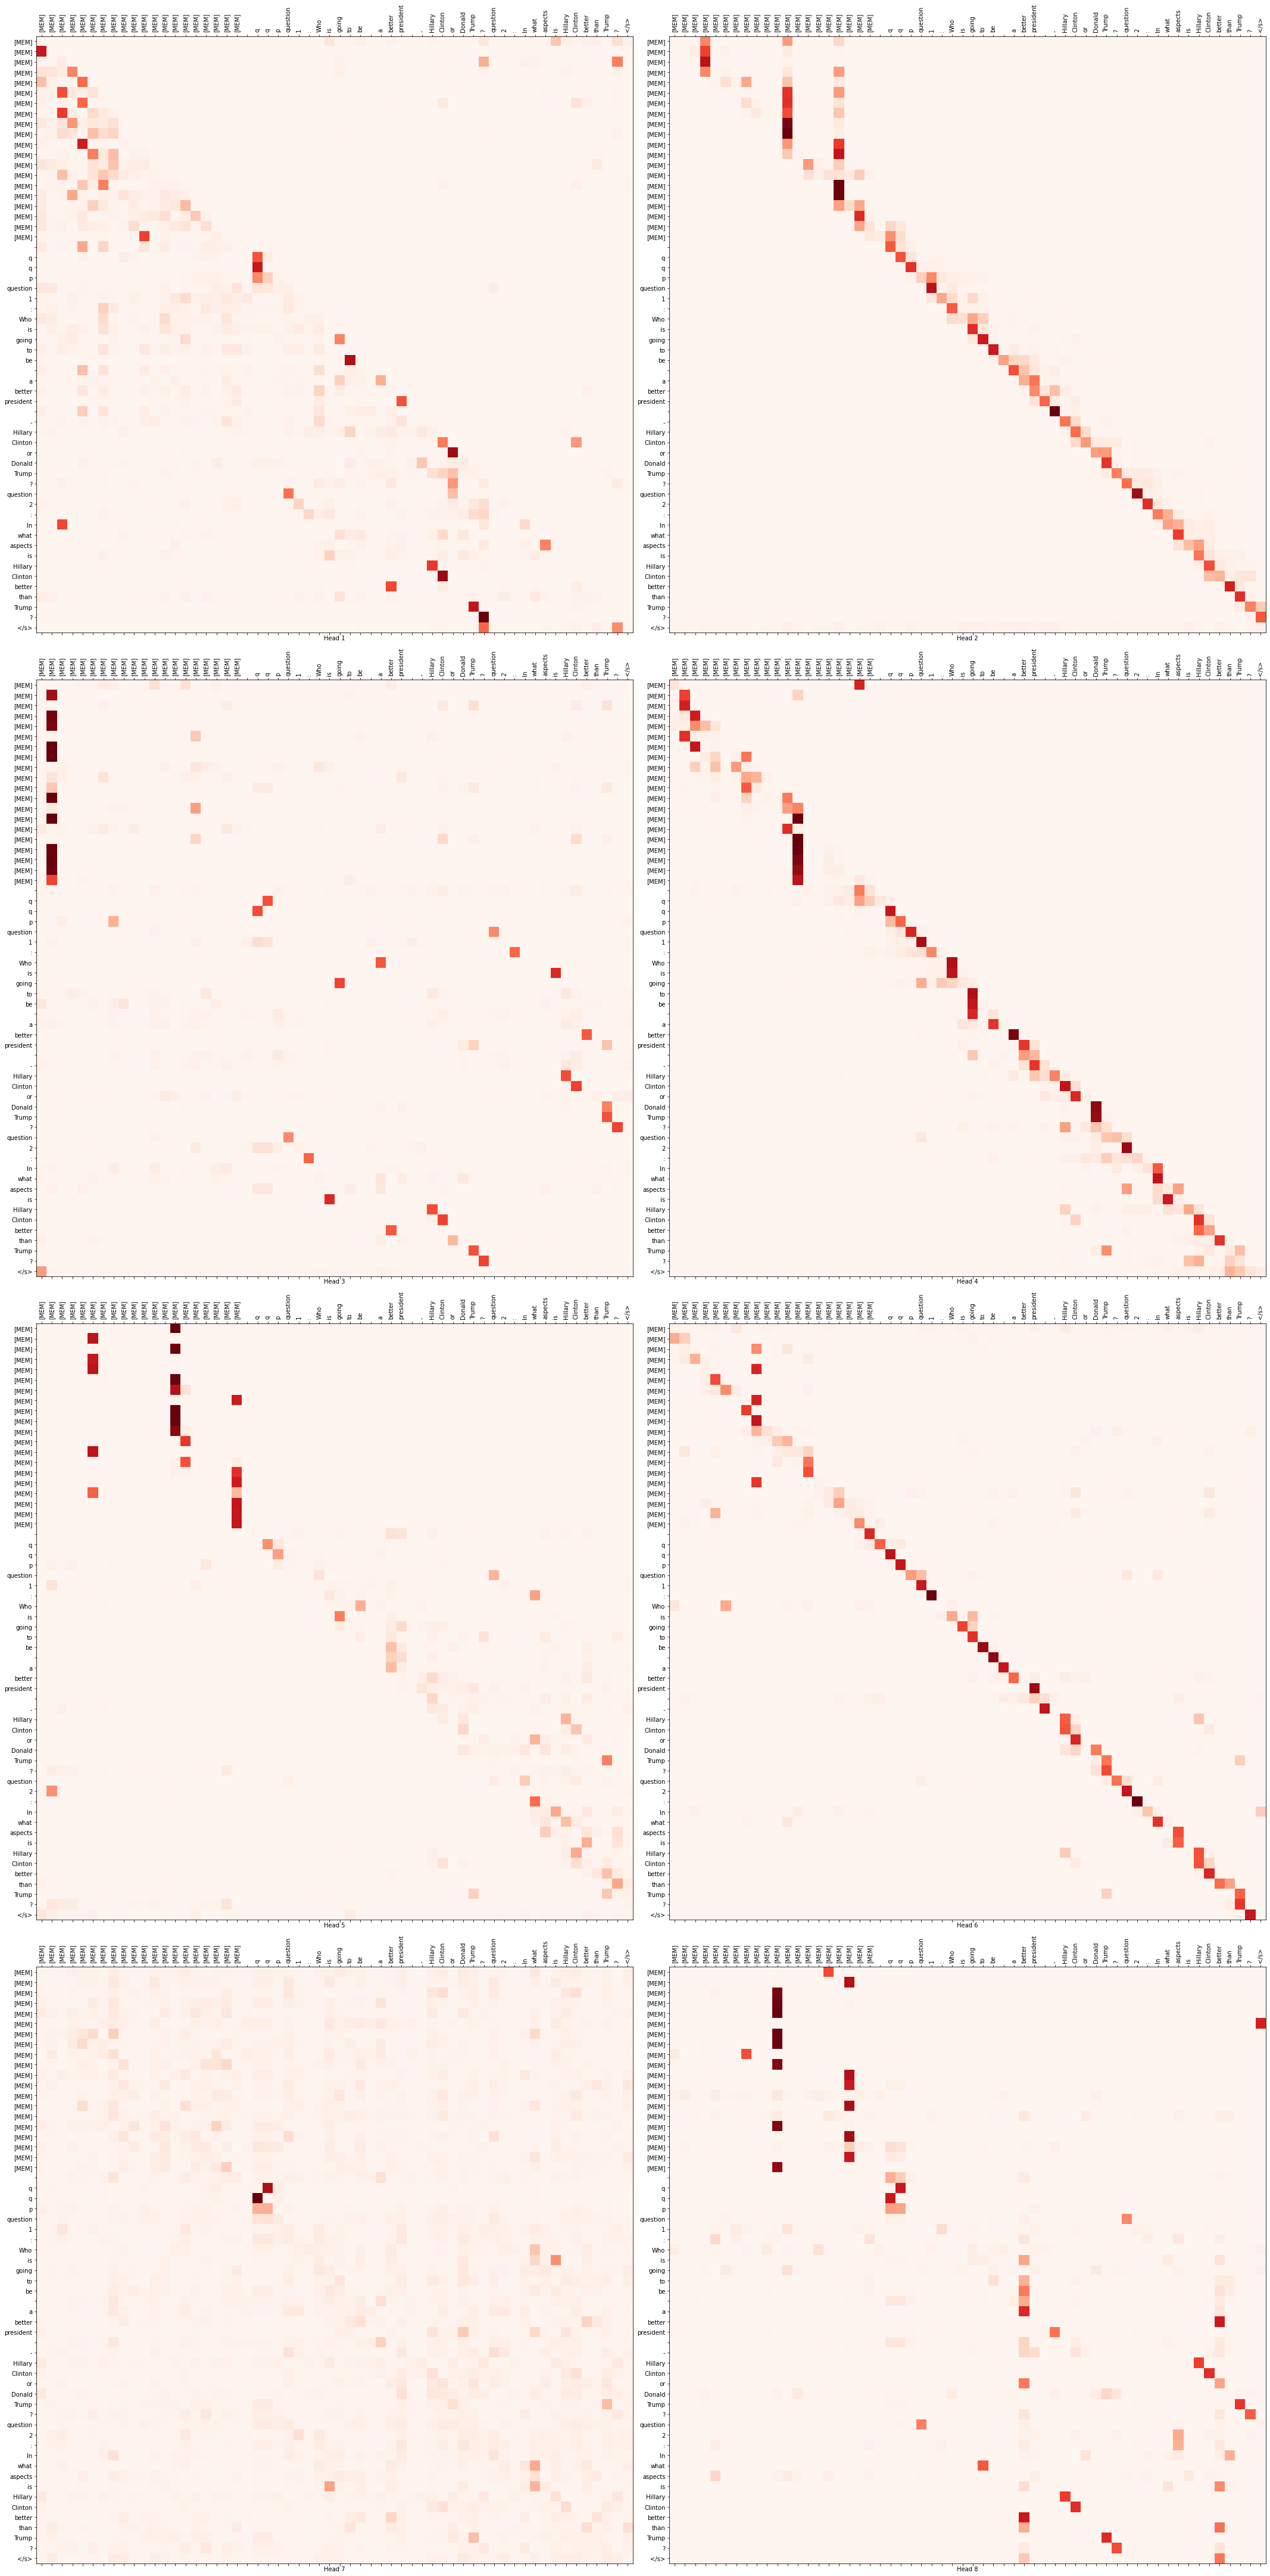

layer: 1
att_heads:


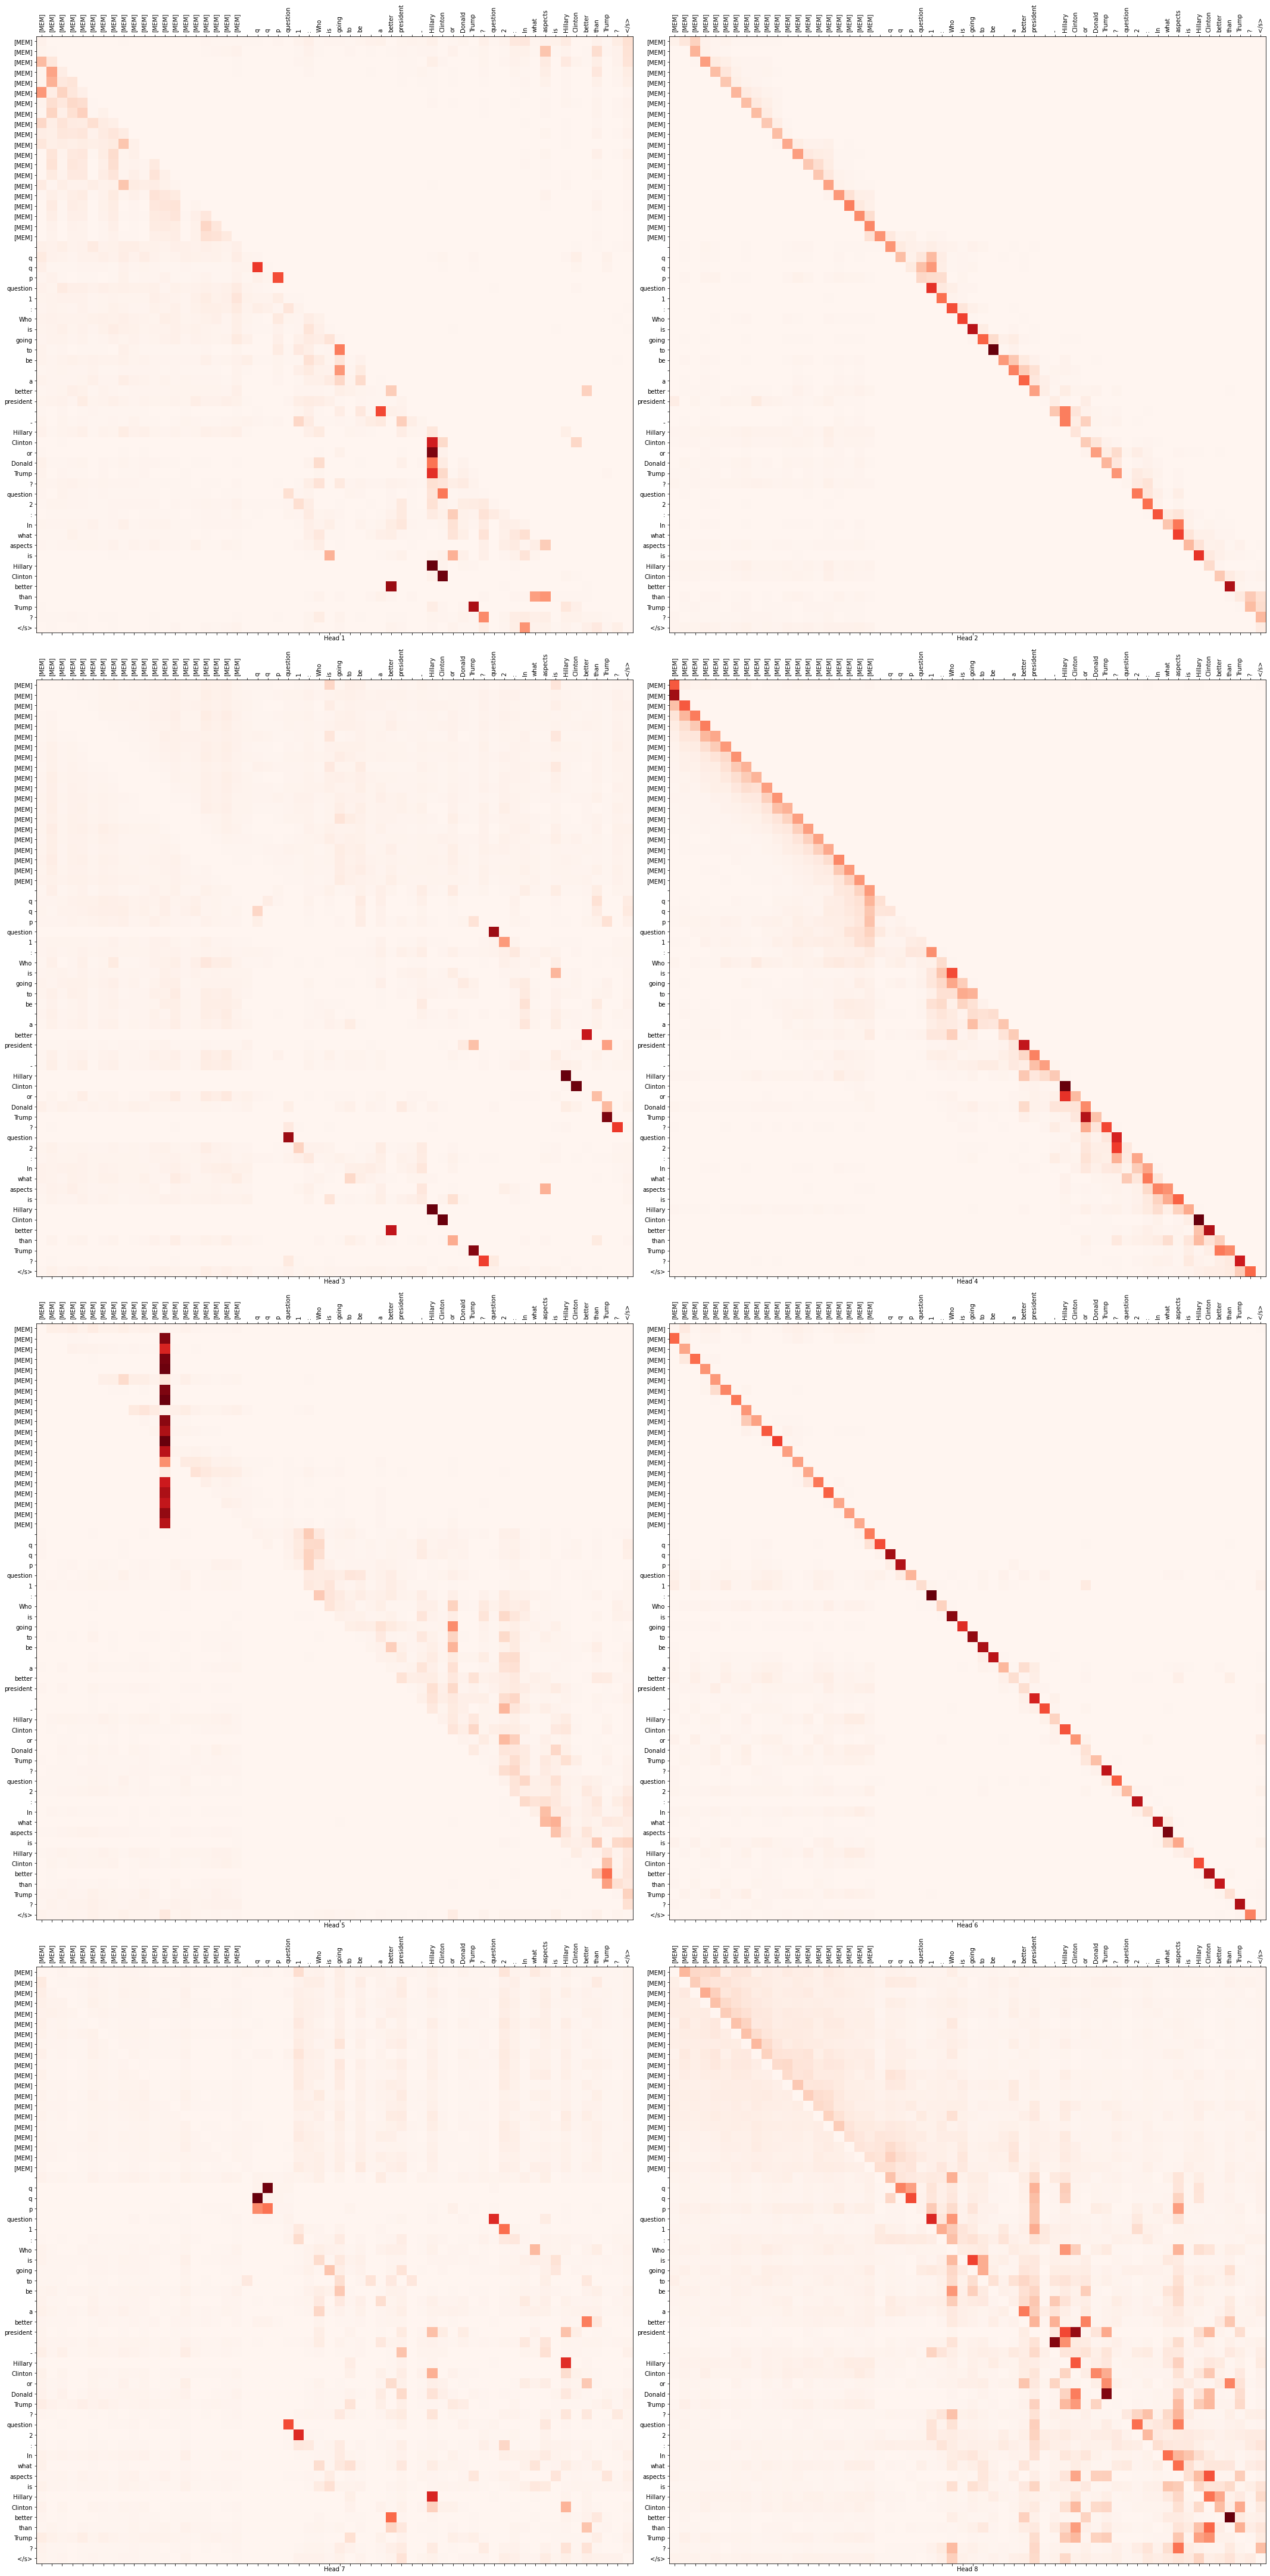

layer: 2
att_heads:


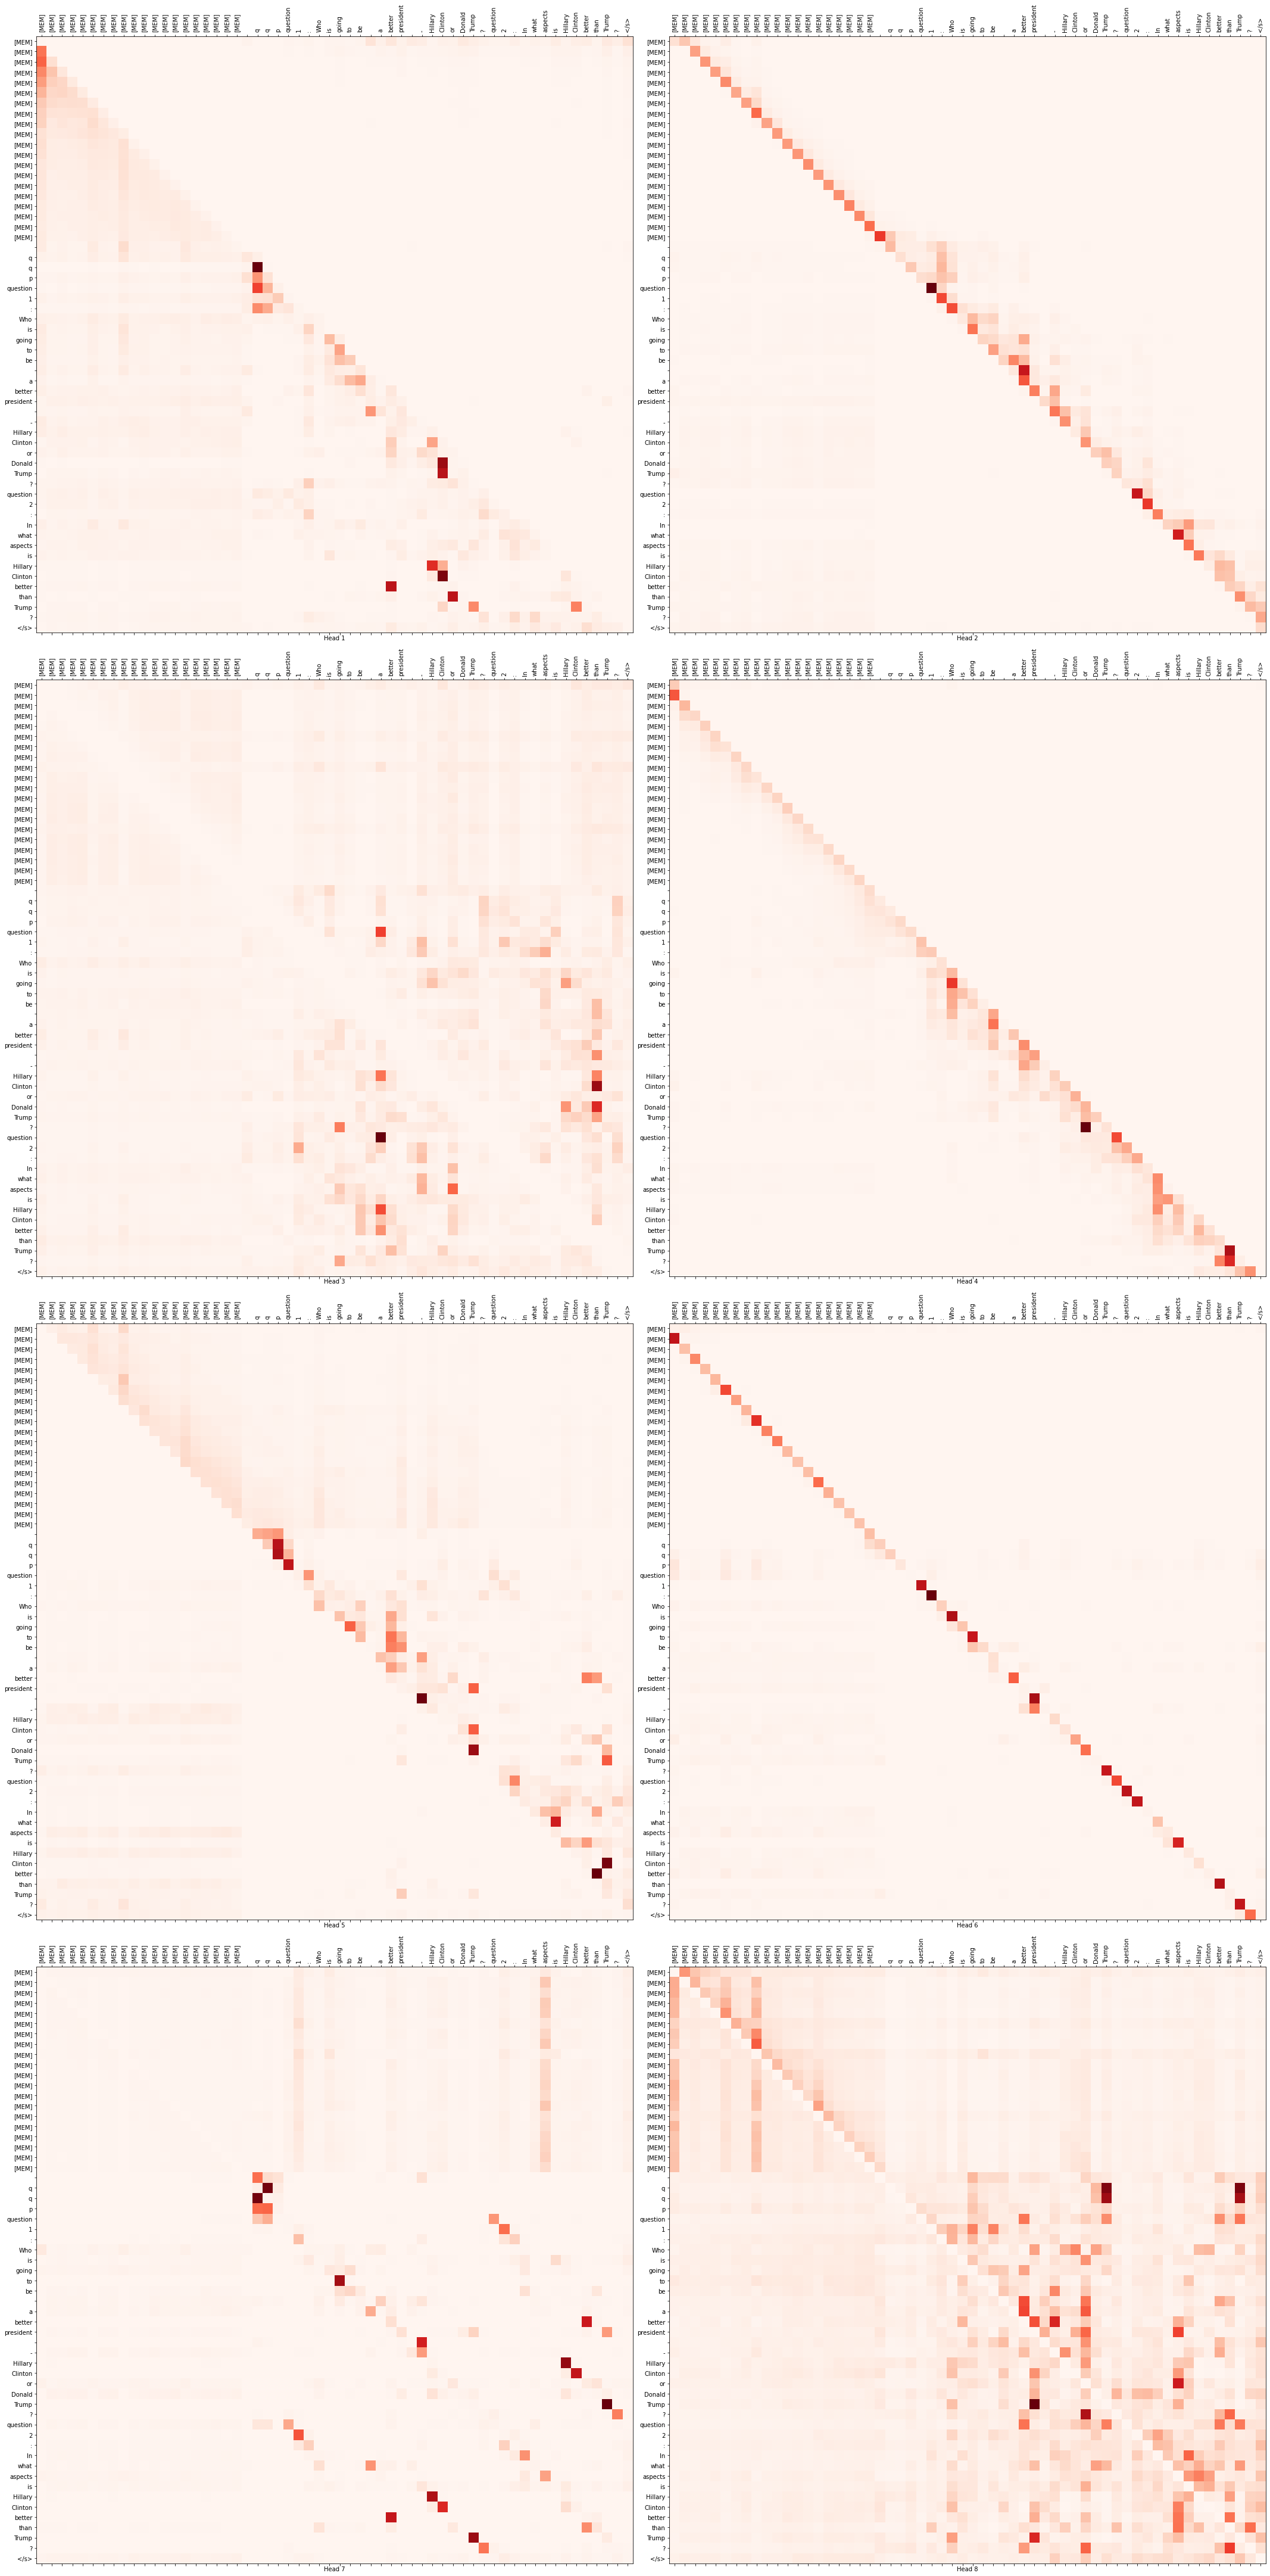

layer: 3
att_heads:


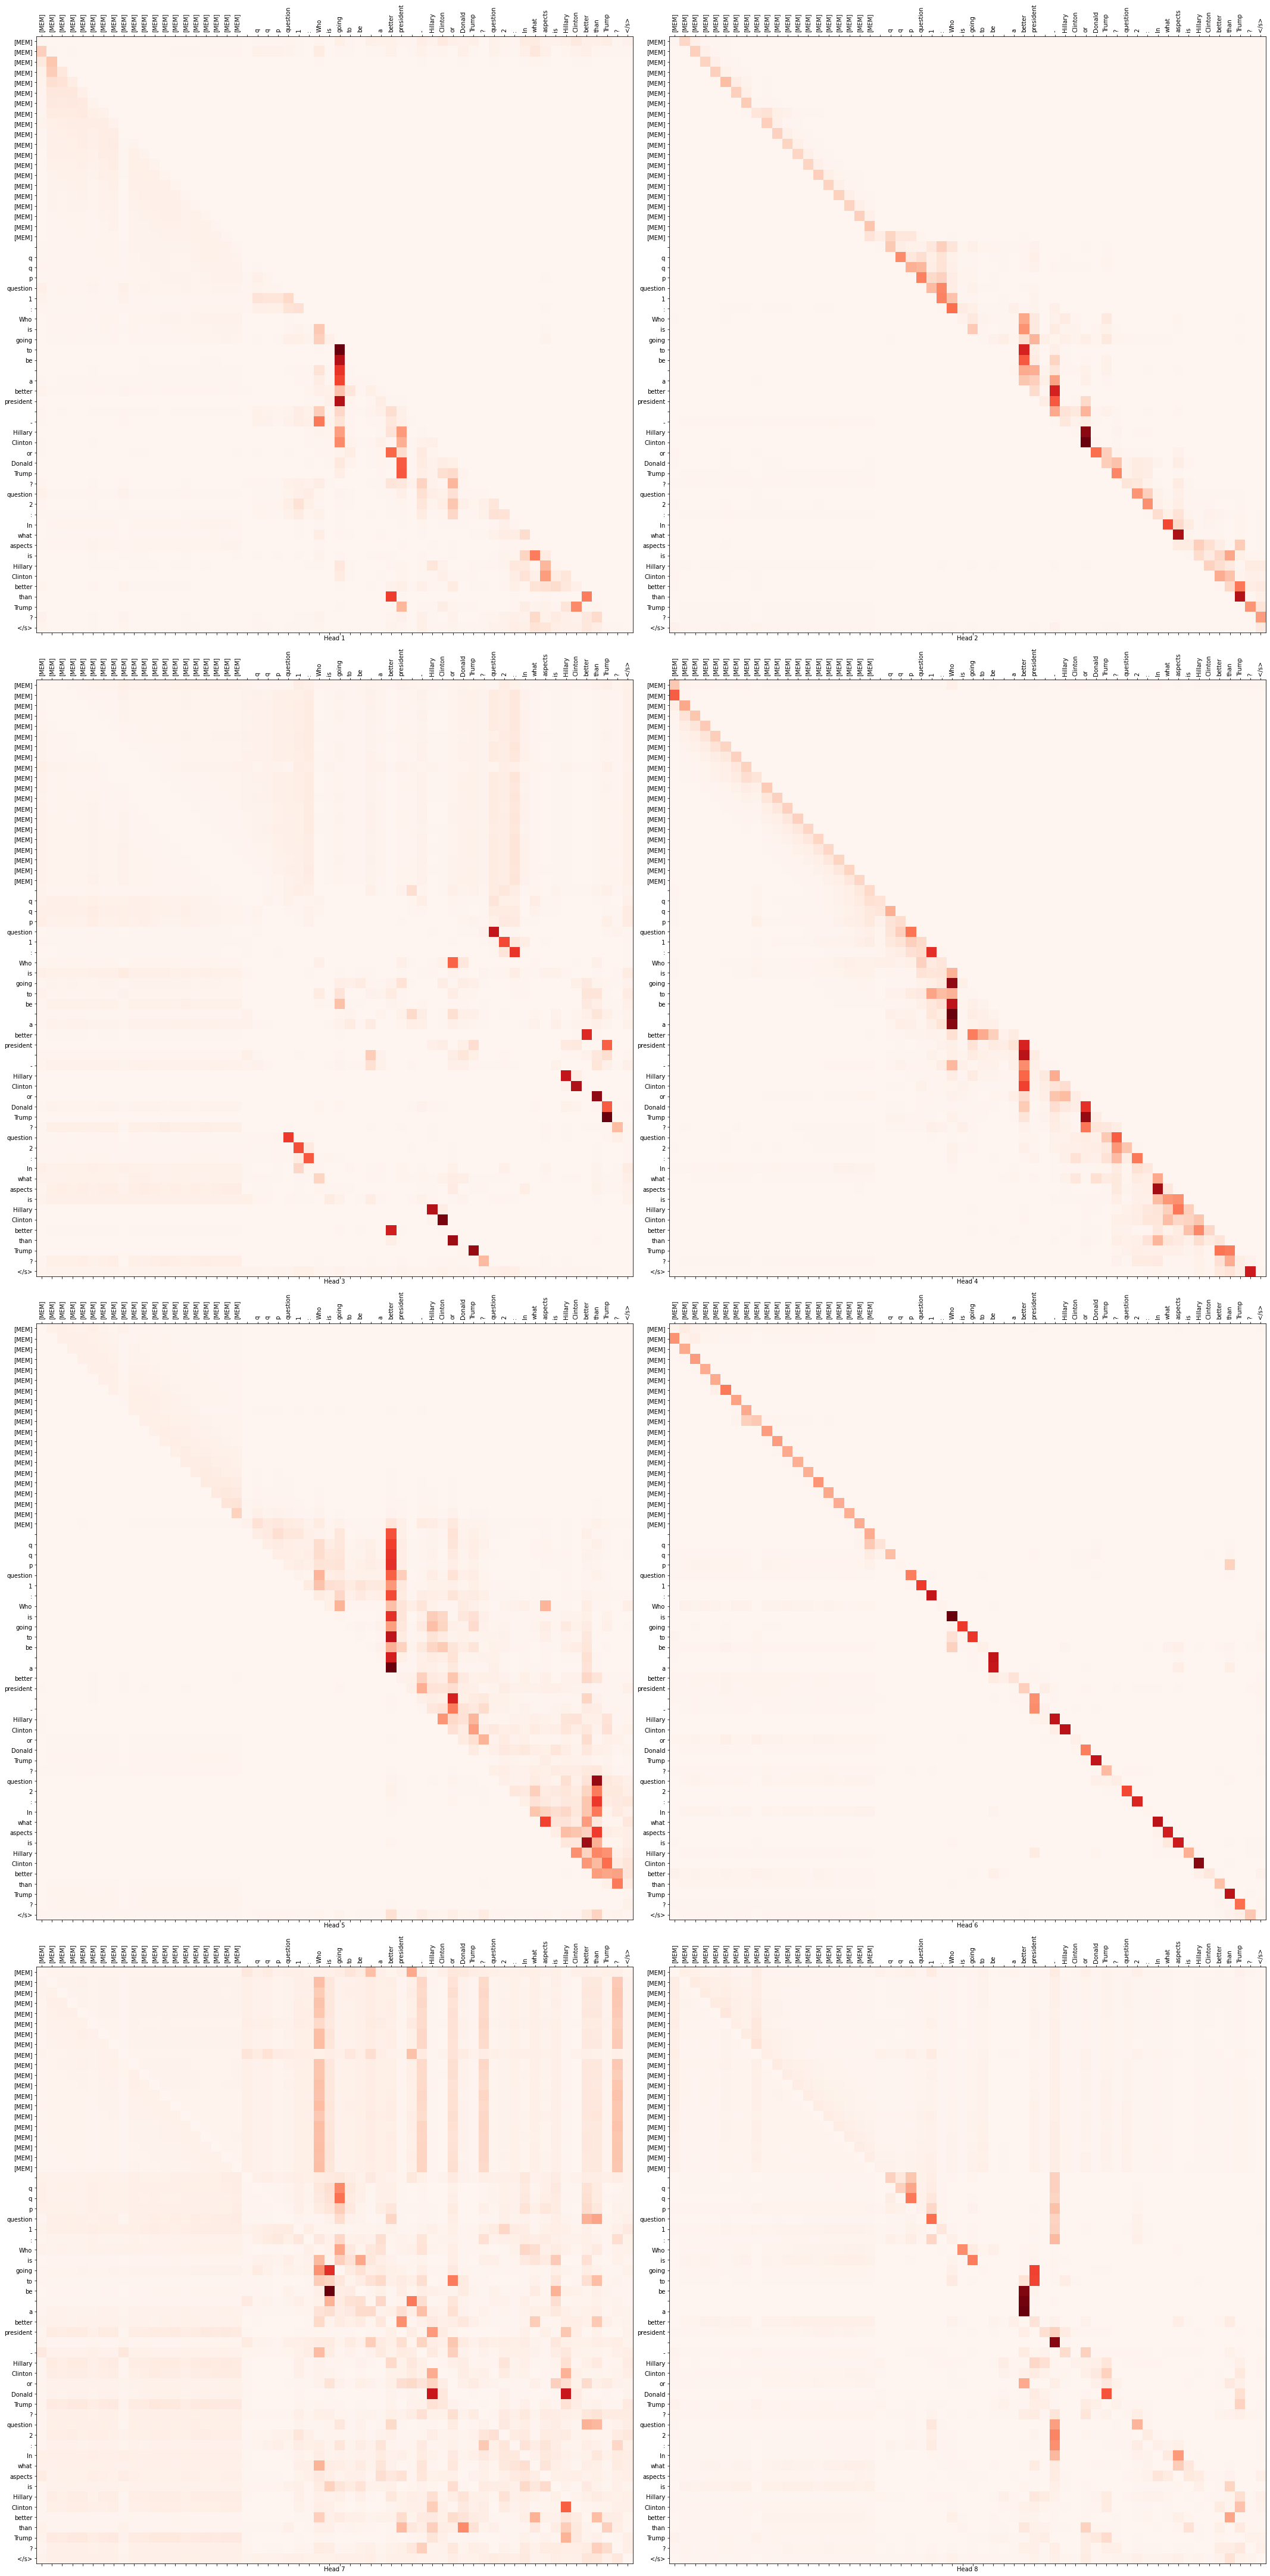

layer: 4
att_heads:


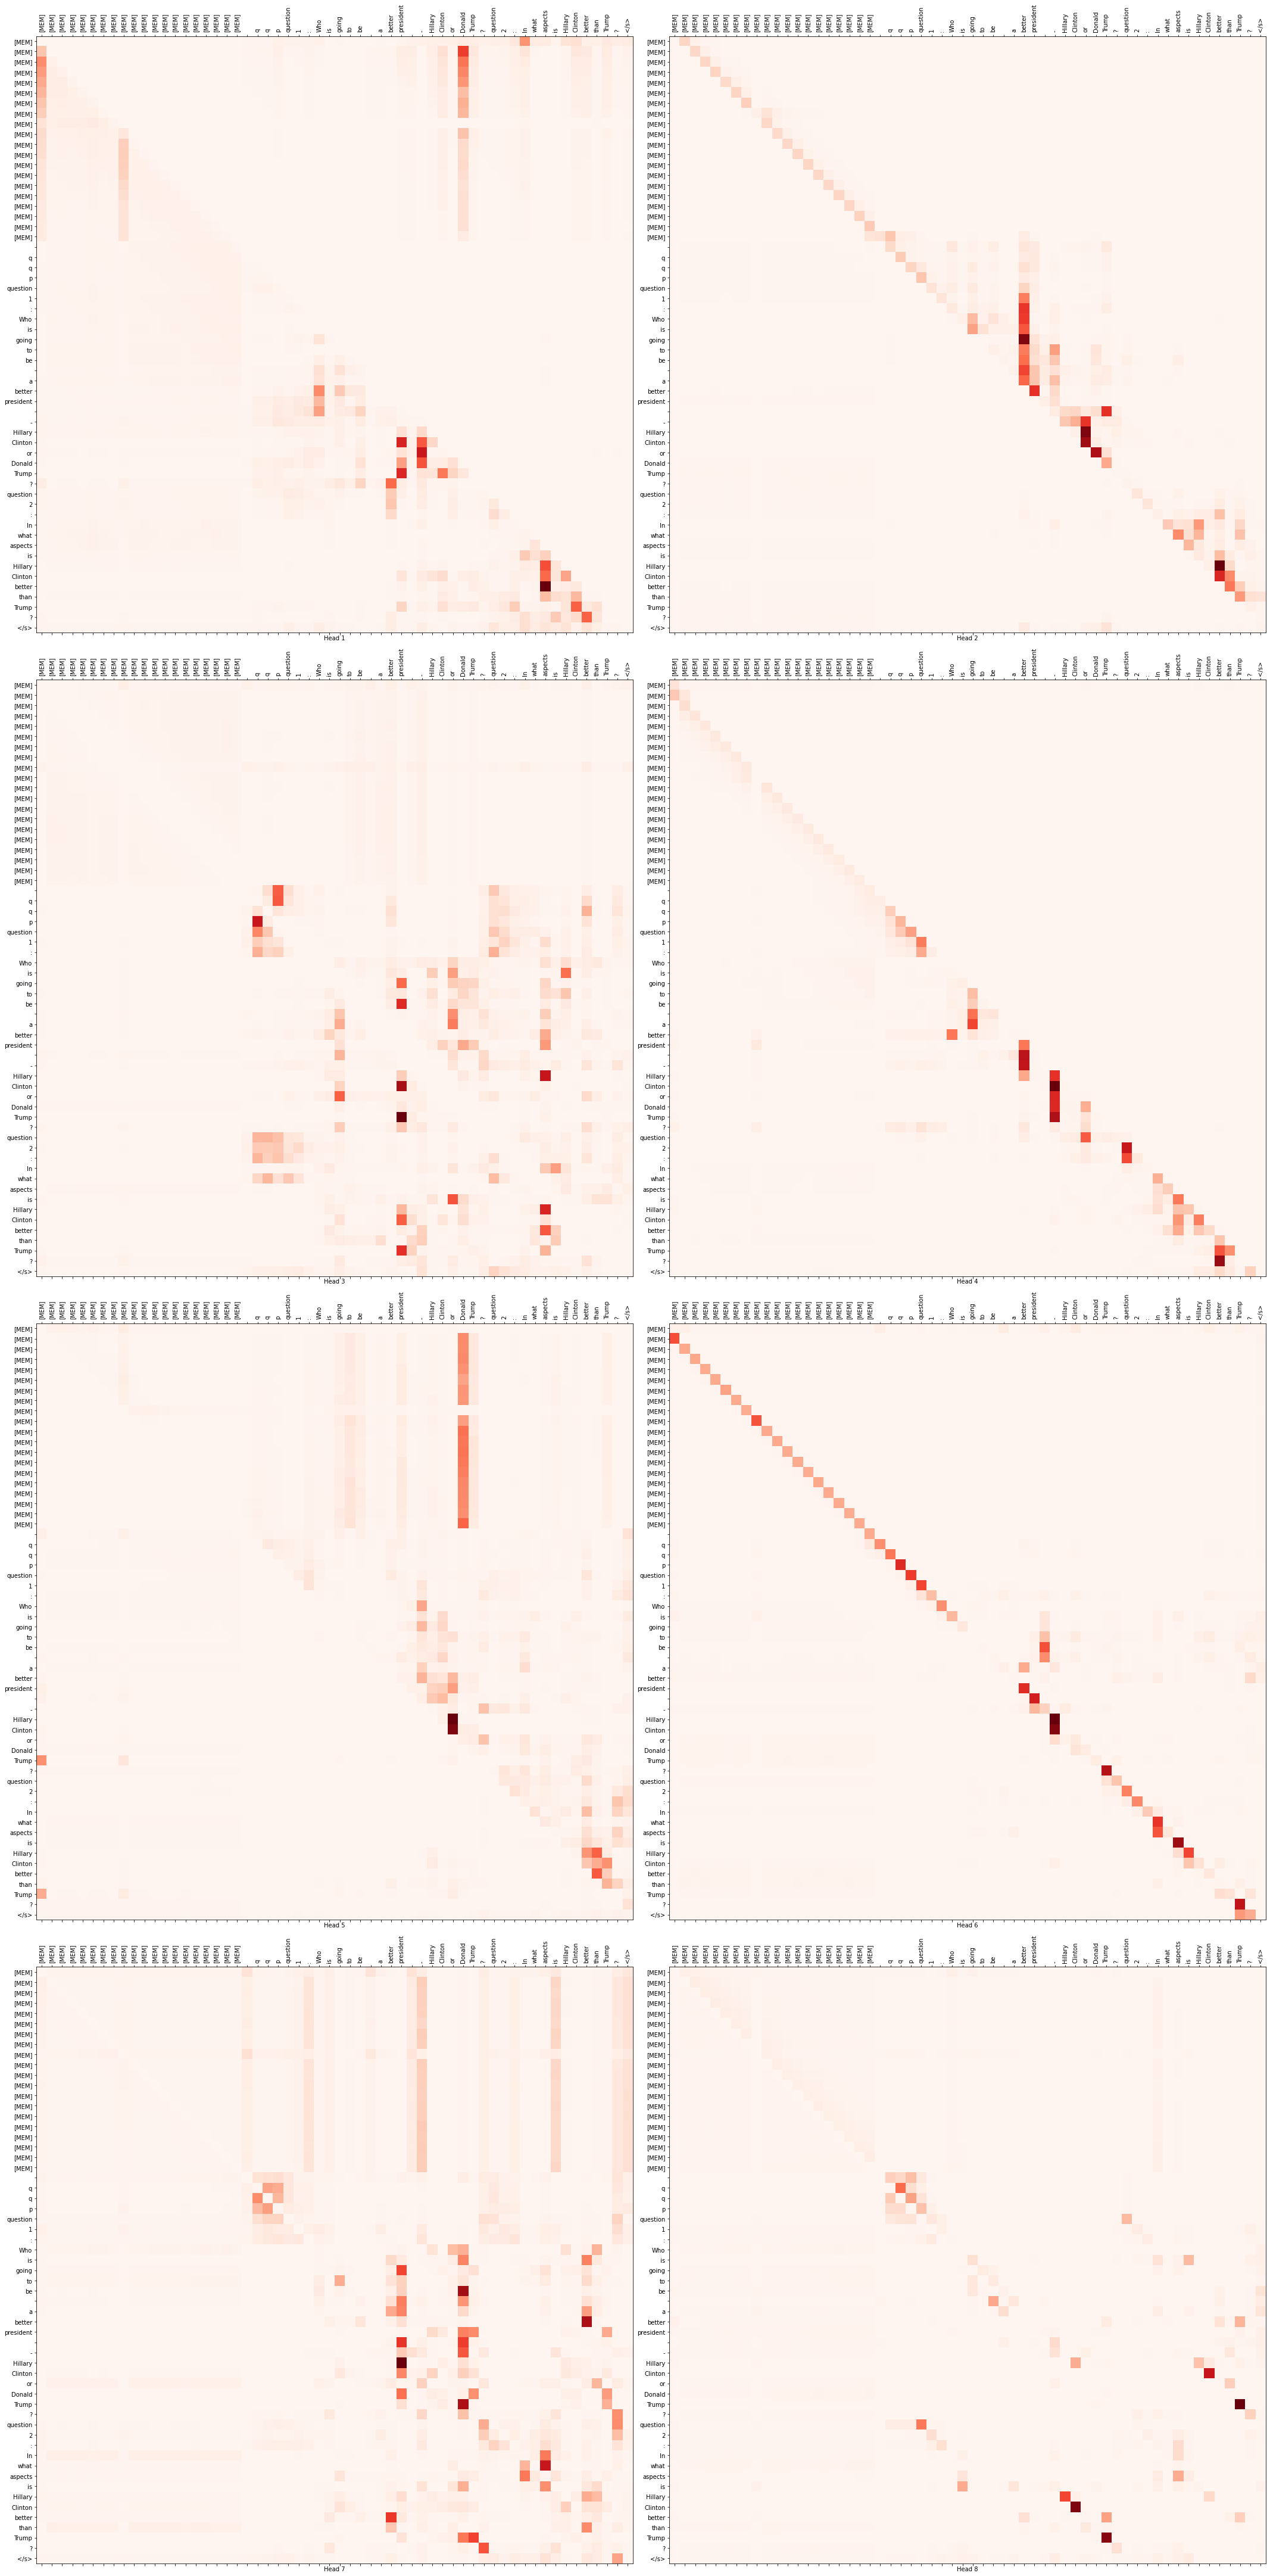

layer: 5
att_heads:


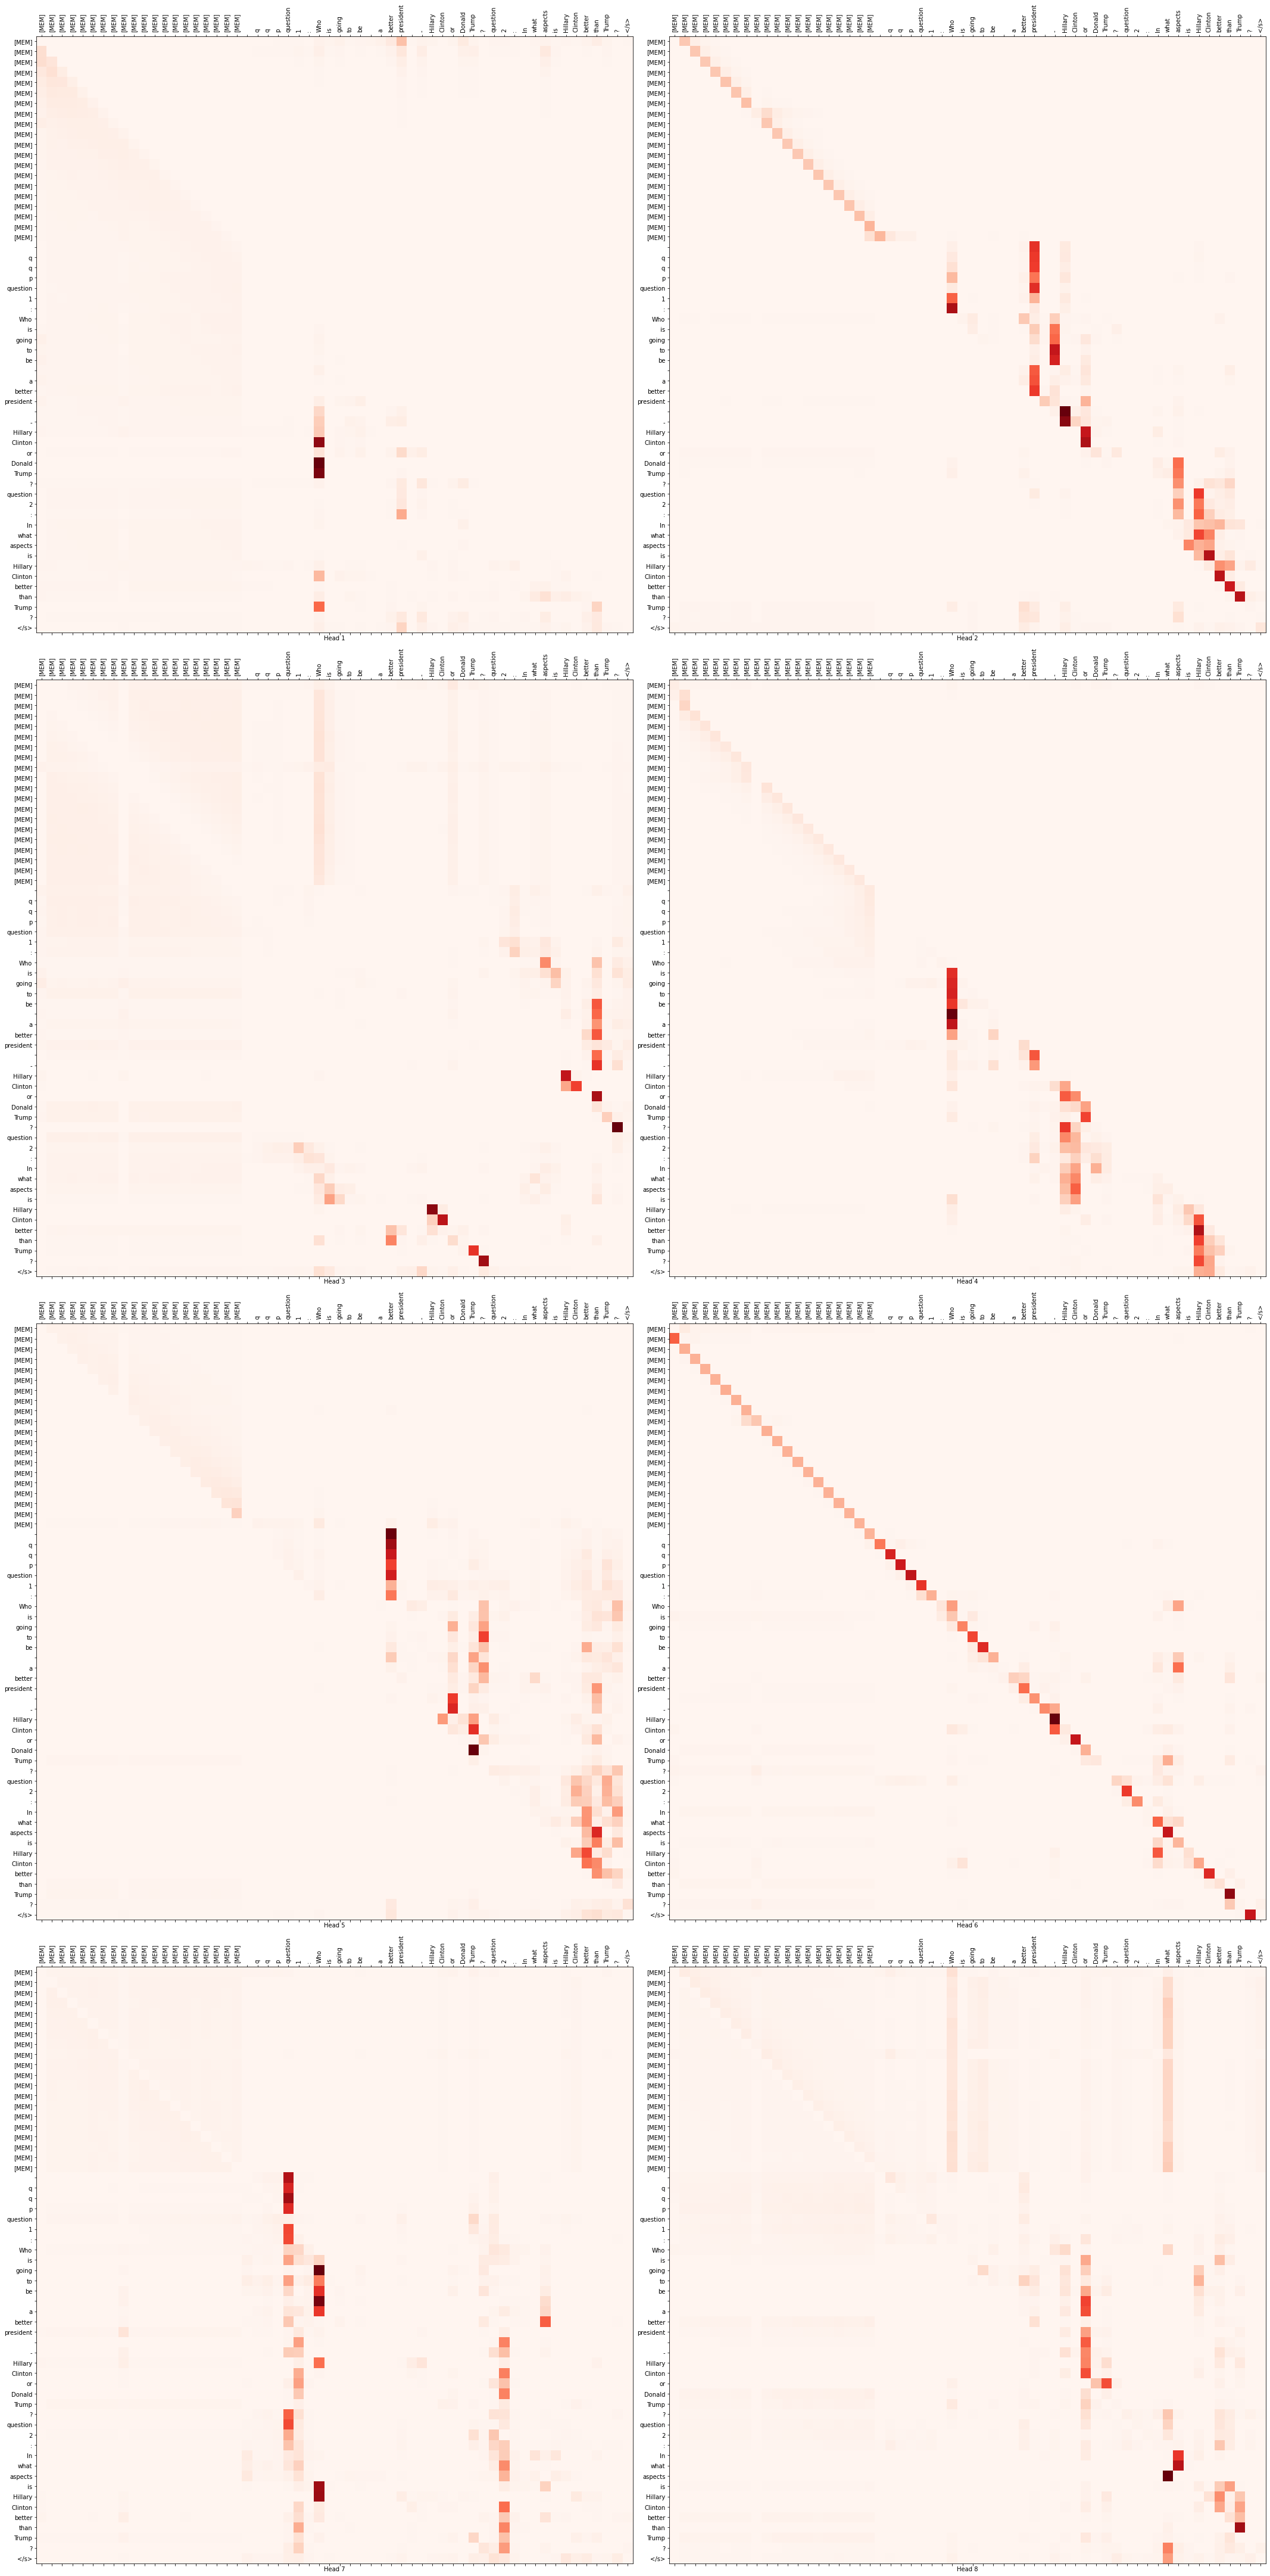

In [41]:
for layer in range(len(outputs['encoder_attentions'])):
    print(f'layer: {layer}')
    if isinstance(outputs['encoder_attentions'][0], tuple):
        attentions = [layer_atts[0].detach().squeeze().numpy() if layer_atts[0] is not None else None for layer_atts in outputs['encoder_attentions']]
        cd_attentions = [layer_atts[1].detach().squeeze().numpy() for layer_atts in outputs['encoder_attentions']]
        p_attentions = [layer_atts[2].detach().squeeze().numpy() for layer_atts in outputs['encoder_attentions']]
    else:
        p_attentions = None
        attentions = [layer_atts.detach().squeeze().numpy() for layer_atts in outputs['encoder_attentions']]
    if attentions[0] is not None:
        # has regular attention heads
        print(f'att_heads:')
        plot_attention_weights(attentions, tokens=tokens, layer=layer, y_tokens=None, p_attentions=None)
    if p_attentions:
        print(f'cdq att heads:')
        plot_attention_weights(cd_attentions, tokens=tokens, layer=layer, y_tokens=None, p_attentions=p_attentions)

cross-attention
layer: 0
att_heads:


<ipython-input-39-1db38d3dffe5>:34: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.set_yticklabels(y_tokens, fontdict)


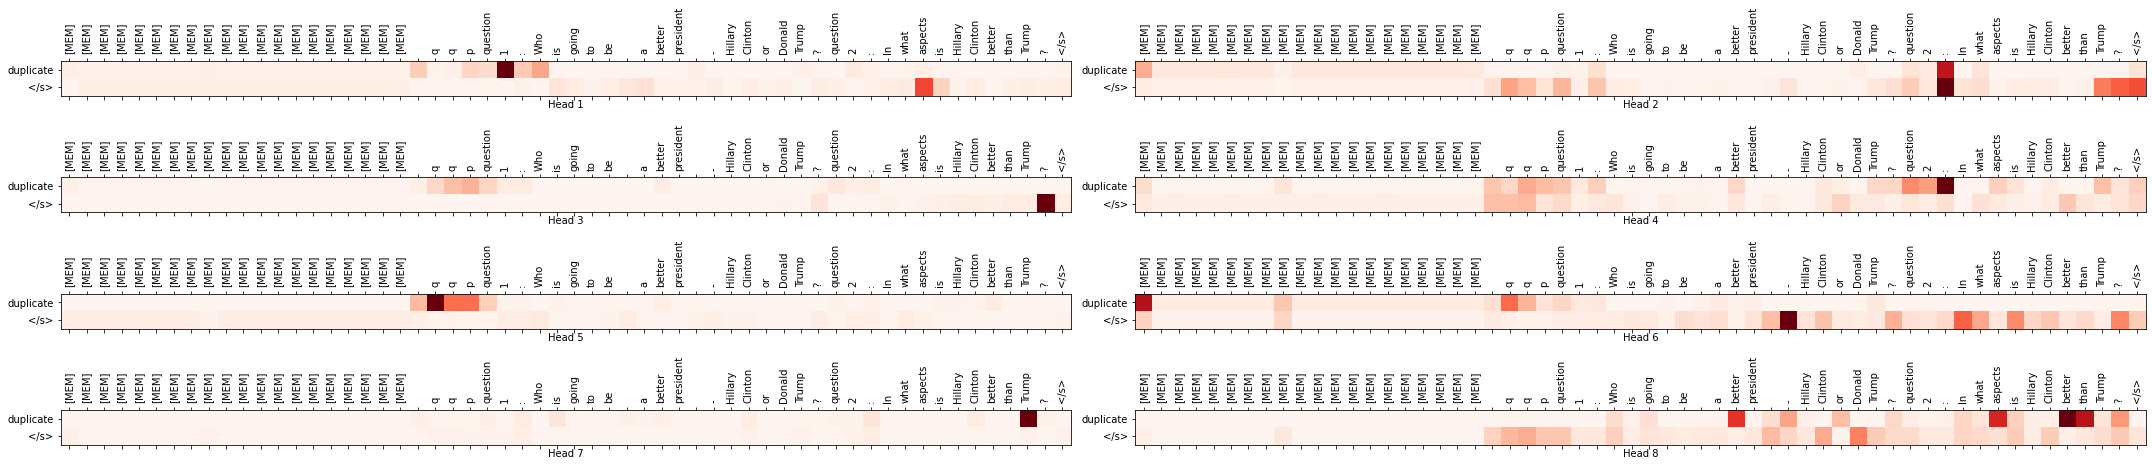

layer: 1
att_heads:


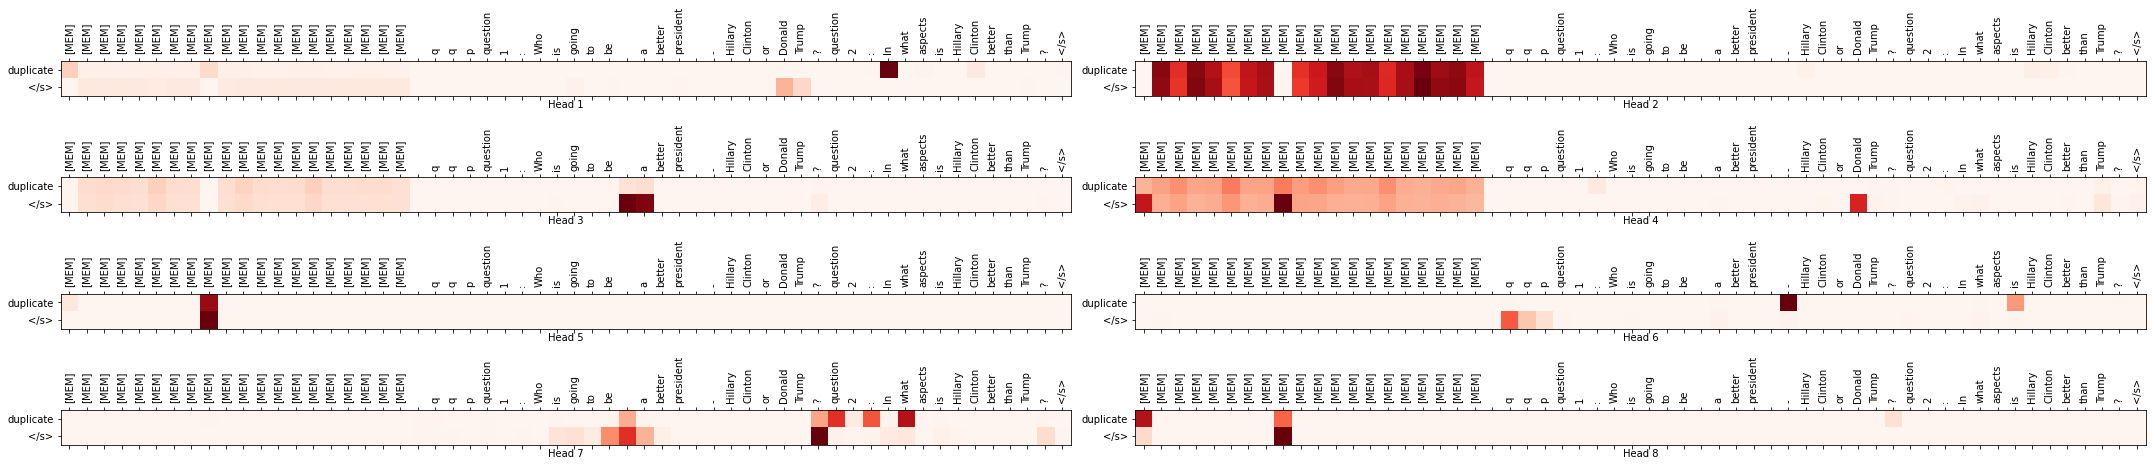

layer: 2
att_heads:


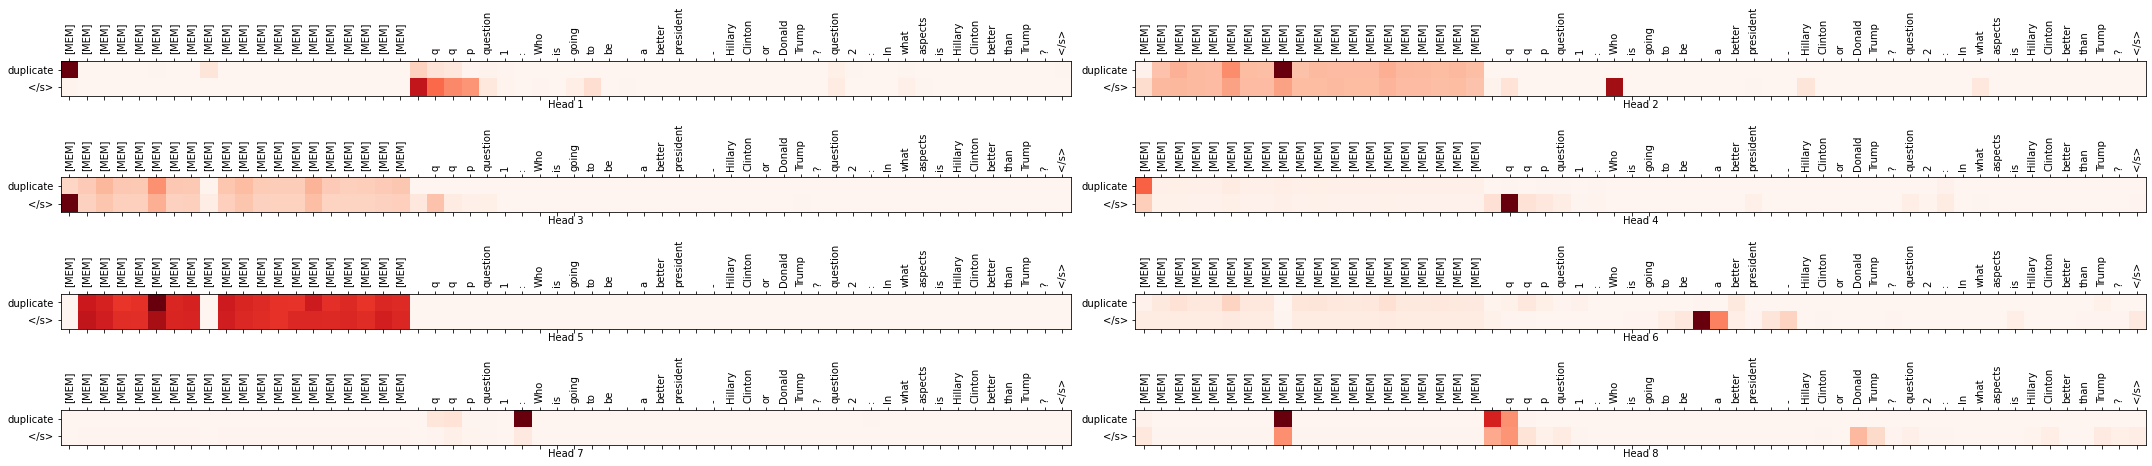

layer: 3
att_heads:


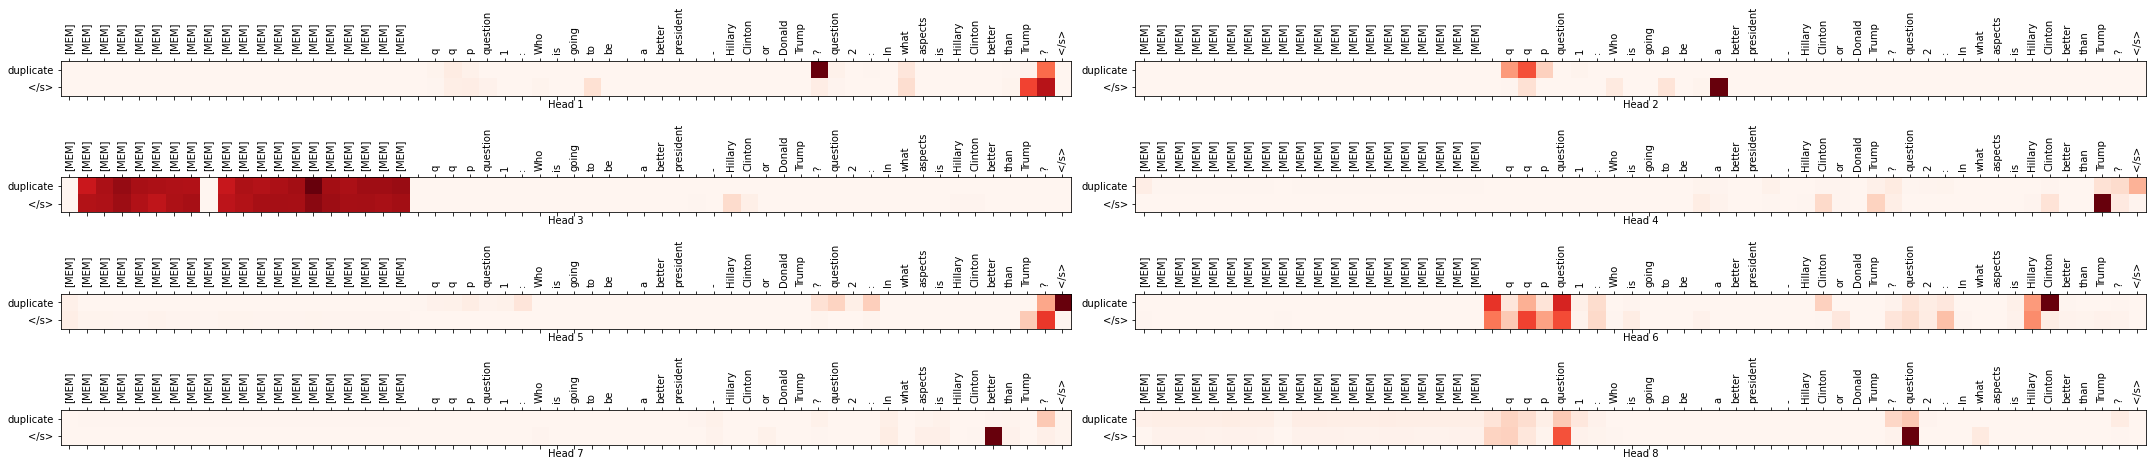

layer: 4
att_heads:


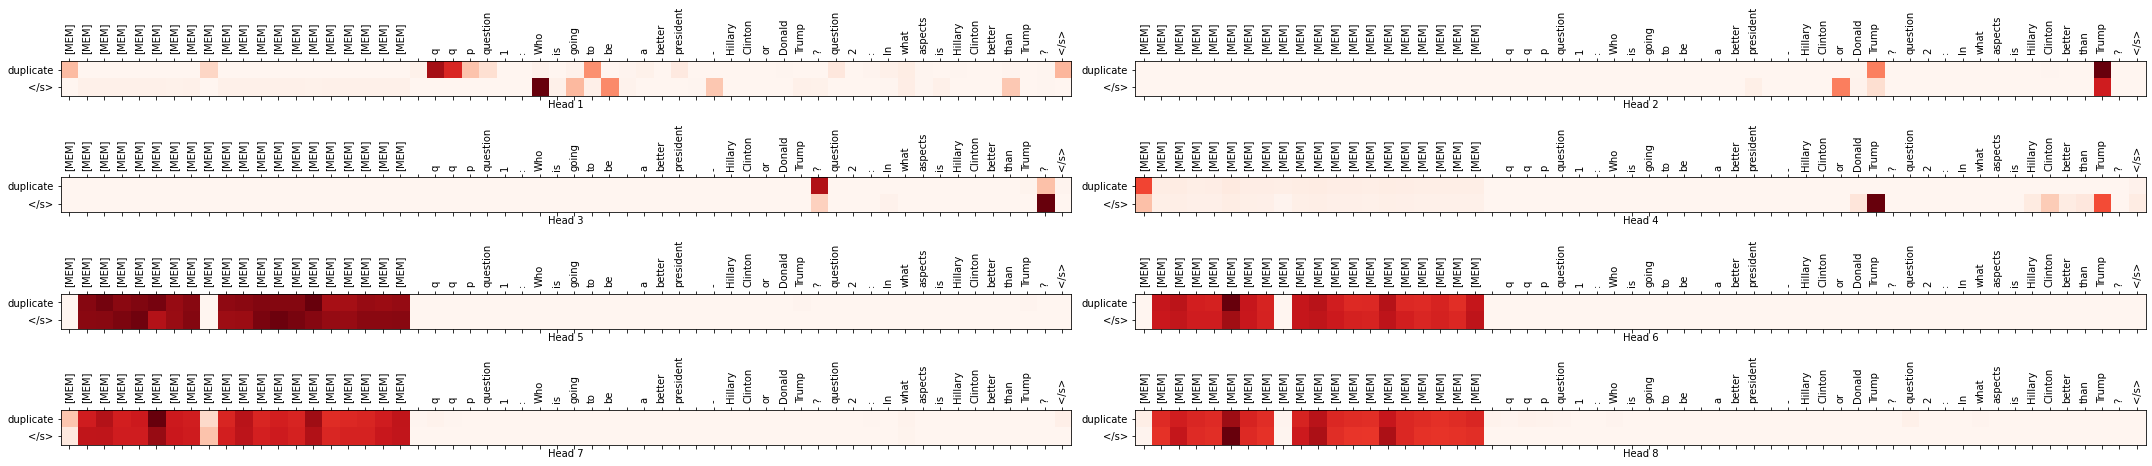

layer: 5
att_heads:


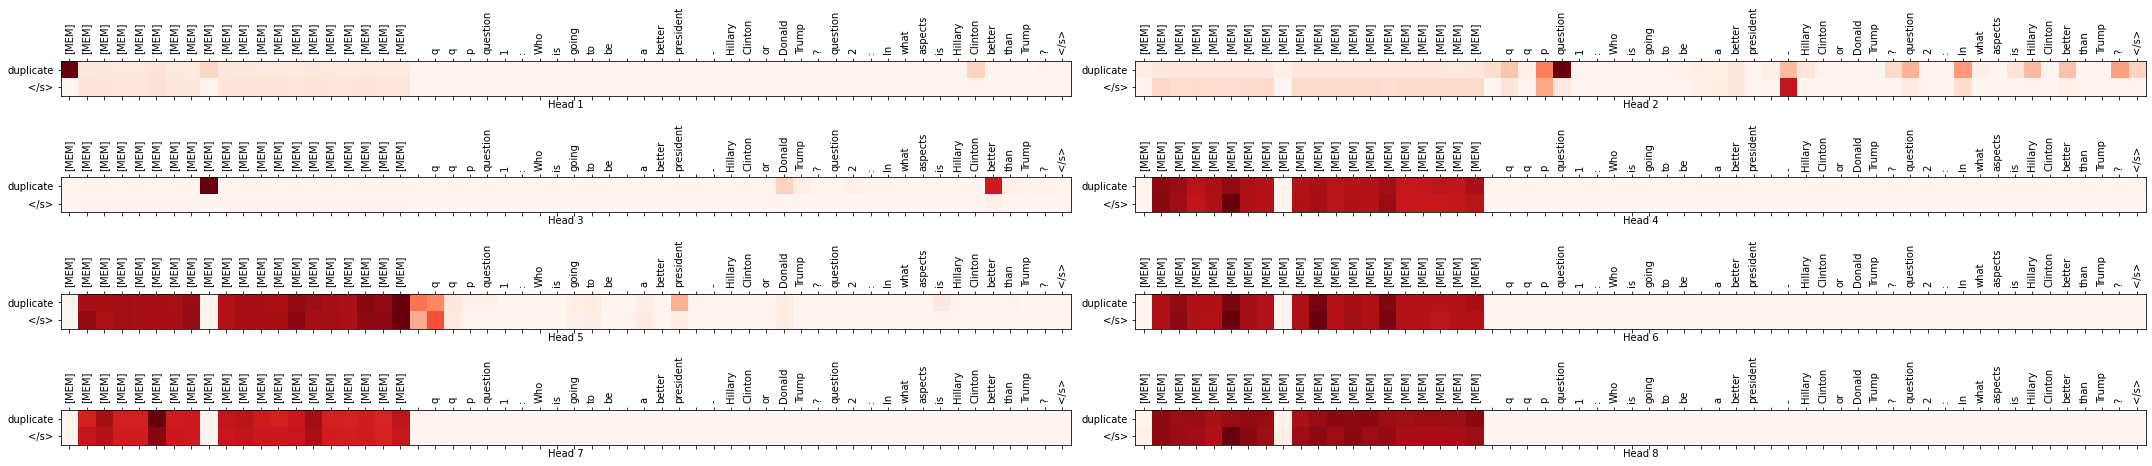

In [42]:
if num_memory_tokens > -1:
    print('cross-attention')
    for layer in range(len(outputs['cross_attentions'])):
        print(f'layer: {layer}')
        if isinstance(outputs['cross_attentions'][0], tuple):
            attentions = [layer_atts[0].detach().squeeze().numpy() if layer_atts[0] is not None else None for layer_atts in outputs['encoder_attentions']]
            cd_attentions = [layer_atts[1].detach().squeeze().numpy() for layer_atts in outputs['cross_attentions']]
            p_attentions = [layer_atts[2].detach().squeeze().numpy() for layer_atts in outputs['cross_attentions']]
        else:
            p_attentions = None
            attentions = [layer_atts.detach().squeeze().numpy() for layer_atts in outputs['cross_attentions']]
        if attentions[0] is not None:
            # has regular attention heads
            print(f'att_heads:')
            plot_attention_weights(attentions, tokens=tokens, layer=layer, y_tokens=y_tokens, p_attentions=None, figsize=(30,10))
        if p_attentions:
            print(f'cdq att heads:')
            plot_attention_weights(cd_attentions, tokens=tokens, layer=layer, y_tokens=y_tokens, p_attentions=p_attentions, figsize=(30,10))